# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [2]:
import os
import keras
import tensorflow as tf
# Disable GPU
# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.75) #占用75%顯存
sess =  tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
         # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            #Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            #Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
           #Dense是全連接層，該層的輸出維度n_units，激活函數='softmax'
    
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model 

In [7]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [0.001, 0.01, 0.1, 1] #學習率
EPOCHS = 50 #訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
OPT = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adagrad, keras.optimizers.Adam] #優化器

In [9]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    for optimizers in OPT:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = {}, OPT={}" .format(lr,OPT))
        model = build_mlp(input_shape=x_train.shape[1:])
        # 用 Keras 內建方法檢視模型各層參數量
        model.summary()
        #優化器參數設定
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizers(lr=lr))
        '''
        參數說明:
        lr：float> = 0.學習率。
        '''
    
    model.fit(x_train, y_train, #訓練資料
              epochs=EPOCHS,   #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  #驗證資料
              shuffle=True) #每次epochs後，將訓練集打亂順序
    
    # Collect results
    #ㄘhistory.history:記錄了損失函數和其他指標的數值隨epoch變化的情況，如果有驗證集的話，也包含了驗證集的這些指標變化情況
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "Experiment with LR = {}, OPT={}" .format(lr,OPT)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}


Experiment with LR = 0.001, OPT=[<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adam'>]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)       

50000/50000 [==============================] - 3s 56us/step - loss: 1.1506 - accuracy: 0.5850 - val_loss: 1.3924 - val_accuracy: 0.5086
Epoch 21/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.1181 - accuracy: 0.5985 - val_loss: 1.3861 - val_accuracy: 0.5115
Epoch 22/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1002 - accuracy: 0.6064 - val_loss: 1.3939 - val_accuracy: 0.5128
Epoch 23/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.0938 - accuracy: 0.6079 - val_loss: 1.4064 - val_accuracy: 0.5161
Epoch 24/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.0621 - accuracy: 0.6206 - val_loss: 1.3977 - val_accuracy: 0.5232
Epoch 25/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.0466 - accuracy: 0.6231 - val_loss: 1.3984 - val_accuracy: 0.5137
Epoch 26/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.0318 - accuracy: 0.6264 - val_loss: 1.4278

Experiment with LR = 0.01, OPT=[<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adam'>]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)        

50000/50000 [==============================] - 3s 54us/step - loss: 1.4259 - accuracy: 0.4970 - val_loss: 1.5300 - val_accuracy: 0.4686
Epoch 48/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4070 - accuracy: 0.4983 - val_loss: 1.5264 - val_accuracy: 0.4651
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4236 - accuracy: 0.4967 - val_loss: 1.4892 - val_accuracy: 0.4774
Epoch 50/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4017 - accuracy: 0.5030 - val_loss: 1.5397 - val_accuracy: 0.4620
Experiment with LR = 0.1, OPT=[<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adam'>]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_____________________________________

50000/50000 [==============================] - 3s 53us/step - loss: 2.3069 - accuracy: 0.1000 - val_loss: 2.3064 - val_accuracy: 0.1000
Epoch 17/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.3067 - accuracy: 0.1001 - val_loss: 2.3046 - val_accuracy: 0.1000
Epoch 18/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.3060 - accuracy: 0.0995 - val_loss: 2.3059 - val_accuracy: 0.1000
Epoch 19/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.3072 - accuracy: 0.0990 - val_loss: 2.3054 - val_accuracy: 0.1000
Epoch 20/50
50000/50000 [==============================] - 3s 57us/step - loss: 2.3076 - accuracy: 0.0989 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 21/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.3067 - accuracy: 0.0995 - val_loss: 2.3063 - val_accuracy: 0.1000
Epoch 22/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.3069 - accuracy: 0.0984 - val_loss: 2.3055

Experiment with LR = 1, OPT=[<class 'keras.optimizers.SGD'>, <class 'keras.optimizers.RMSprop'>, <class 'keras.optimizers.Adagrad'>, <class 'keras.optimizers.Adam'>]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (Dense)           

50000/50000 [==============================] - 3s 54us/step - loss: 2.3376 - accuracy: 0.0989 - val_loss: 2.3508 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.3403 - accuracy: 0.1014 - val_loss: 2.3632 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.3306 - accuracy: 0.0982 - val_loss: 2.3431 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.3319 - accuracy: 0.1007 - val_loss: 2.3360 - val_accuracy: 0.1000


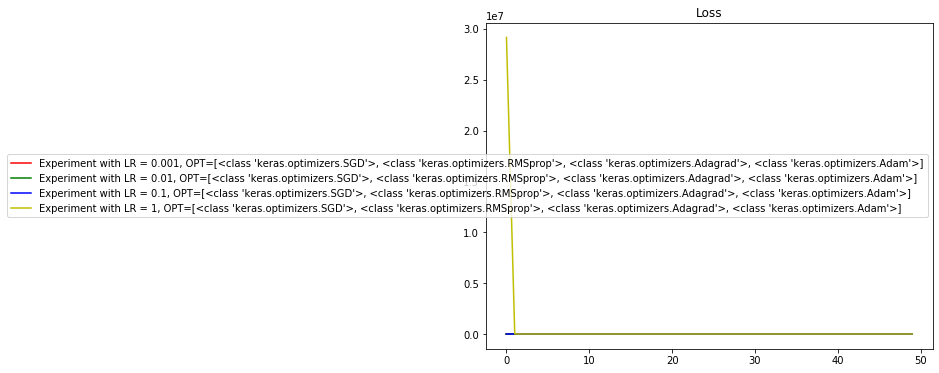

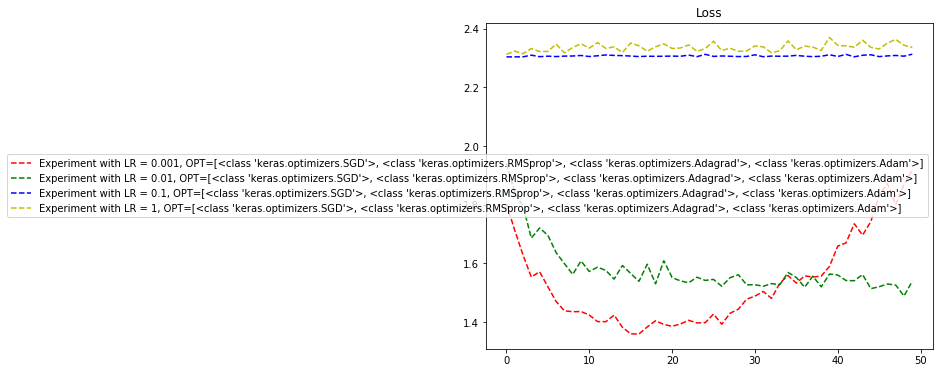

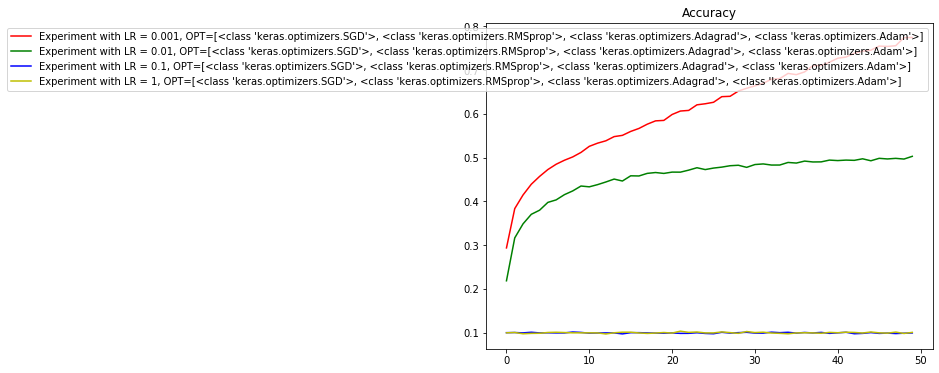

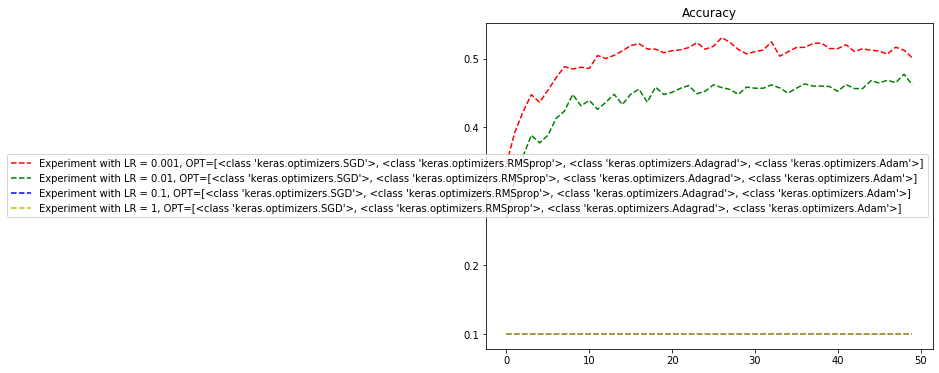

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()